In [3]:
import OffsetArrays
using Plots
using Revise
using StatsBase
using ProgressMeter
using SparseArrays, LinearAlgebra, IndexedGraphs, Graphs
srcpath = "../src"
include("$srcpath/functions.jl")

avgAUC (generic function with 1 method)

In [25]:
# S=0   I=1
# The times go from ti = 0 to ti=T+1
# when ti=0 it means that i is the zero patient
# when ti=T+1 it means that i is never infected

λp = 0.3 # planted infection rate
λi = 0.3 #inferred infection rate

degreetype = "regular";
degreeype = "poisson";

d = 3 # degree 
T = 4 # discrete time

γp = 0.2 # planted autoinfection probability
γi = 0.2 # inferred autoinfection probability

N = 1000; #population size



# Population dynamics for the messages

In [26]:
marg = pop_dynamics(N, T, λp, λi, γp, γi, degreetype, d, tot_iterations = 10, fr = 0.0, dilution = 0.0);
marg2D = reshape((sum(marg,dims=1)./ N),T+2,T+2);

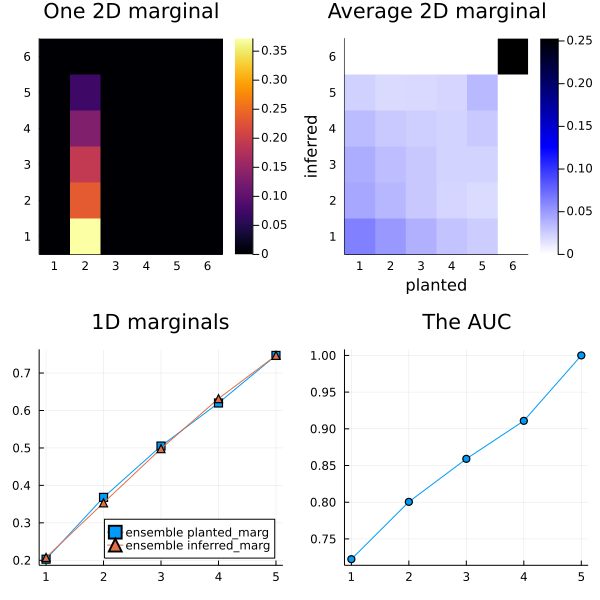

In [41]:
p1 = heatmap(reshape((marg[rand(1:N),:,:]),T+2,T+2),title="One 2D marginal")
p2 = plot(avgAUC(marg),label="ens_AUC",marker=:c,legend=false,title="The AUC")
pheat = heatmap((marg2D),c=[:white,:blue,:black],xlabel="planted",ylabel="inferred",title="Average 2D marginal")
p0 = plot(cumsum(sum(marg2D,dims=1)'[1:end-1],dims=1),marker=:square,label="ensemble planted_marg",title="1D marginals")
p0 = plot!(cumsum(sum(marg2D,dims=2)[1:end-1],dims=1),marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)
plot(p1,pheat,p0,p2,size=(600,600))

# Single Instance Inferernce with Sib

## No disorder
In this regime we don't have disorder, in the sense that the planted distribution is a delta. The planted observation is "all infected"

## General framework with disorder
Here the results of observations change because the parameter regime is non trivial. Therefore we need to sample a planted configuration, observe this configuration at final time and infere the single instance. We do this many times and we average so to compare with the ensemble results

### Check of the planted distribution
Here we check with a sampler and with sibyl that the planted ensemble marginal is correct.

In [27]:
function makeGraph(Ngraph,d,degreetype)
    if degreetype == "poisson"
        return erdos_renyi(Ngraph, d) |> IndexedBiDiGraph
    elseif degreetype == "regular"
        return random_regular_graph(Ngraph,d) |> IndexedBiDiGraph 
    end
end

makeGraph (generic function with 1 method)

In [28]:
include("$srcpath/sampler.jl")
include("$srcpath/BP.jl")

Ngraph = 1000 # size of the single instance graph
x = zeros(Int,Ngraph, T + 1) # a single epidemic trajectory

# First we initialize a single instance marginal y
# which will be the average over graph and particles
# and epidemic trajectory of the marginals
y = zeros(T+1)
yBP = zero(y)
# we average over totst iterations
totst = 3
@showprogress for st = 1:totst
    # for every iteration we initialize a new graph
    G = makeGraph(Ngraph,d,degreetype)
    # we sample an epidemic
    sample!(x, G, λp, γp)
    # we calculate the cumulative marginal (non-normalized)
    # and we sum it to the average marginal
    y .+= sum(x,dims=1)'
    p_sib = sibyl(Ngraph, T+1, G, [], γi, λi; maxit = 40, tol = 1e-2);
    avgmarg = sum(p_sib,dims=1)' ./ Ngraph
    yBP .+= avgmarg
end
#we normalize the average marginal
y ./= (Ngraph * totst)
yBP ./=  totst;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08



sib.iterate(damp=0.0): 4/40 9.570e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.763e-04/0.01      
sib.iterate(damp=0.9): 0/40 3.381e-04/0.01      
sib.iterate(damp=0.0): 5/40 6.323e-04/0.01      
sib.iterate(damp=0.5): 0/40 3.053e-16/0.01      
sib.iterate(damp=0.9): 0/40 1.943e-16/0.01      
sib.iterate(damp=0.0): 5/40 7.582e-04/0.01      
sib.iterate(damp=0.5): 0/40 3.053e-16/0.01      


In [39]:
p0 = plot(y,c=:black,marker=:circle,label="single_inst sampled marginal",title="γ=$γp, λ=$λp")
p0 = plot!(yBP,c=:red,marker=:circle,label="single_inst BP planted marginal")
p0 = plot!(cumsum(sum(marg2D,dims=1)'[1:end-1],dims=1),c=:blue,marker=:square,size=(350,300),label="ensemble planted_marg",legend=:topleft);

### Comparison between inference (sibyl) and ensemble results
Here we check instead the results for the inferred marginal

In [31]:
yBP = zeros(T+1)
yBPerr = zero(yBP)
@showprogress for st = 1:totst
    # for every iteration we initialize a new graph
    G = makeGraph(Ngraph,d,degreetype)
    # we sample an epidemic
    sample!(x, G, λp, γp)
    # observations set in the form of 
    # [(individual,state,observation time, false_rate of the test)]
    # where state ∈ {0,1} respectively for S and I
    # The reason why there is a T+1 is that sibyl starts from time 1 to time T. 
    # Instead the ensemble goes from time 0 to time T  
    O = [(i,x[i,T+1],T+1,1e-10) for i = 1:Ngraph]
    #we now run the BP algorithm for the single instance defined above
    p_sib = sibyl(Ngraph, T+1, G, O, γi, λi; maxit = 40, tol = 1e-2);
    yBP .+= sum(p_sib,dims=1)'
    yBPerr .+= sum(p_sib ,dims=1)' .^ 2
end

yBP ./= (Ngraph * totst);
#yBPerr ./= (Ngraph^2 * totst)
#yBPerr .= sqrt.(yBPerr .- yBP .^ 2) / sqrt(totst)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07



sib.iterate(damp=0.0): 6/40 8.941e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.617e-03/0.01      
sib.iterate(damp=0.9): 0/40 3.372e-03/0.01      
sib.iterate(damp=0.0): 6/40 4.840e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.108e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.555e-03/0.01      
sib.iterate(damp=0.0): 7/40 5.404e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.910e-03/0.01      


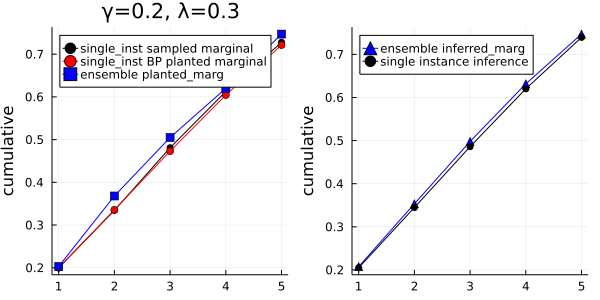

In [32]:
p1 = plot(cumsum(sum(marg2D,dims=2),dims=1)[1:end-1],c=:blue,marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)
p1 = plot!(yBP,c=:black,marker=:circle,label="single instance inference")
plot(p0,p1,size=(600,300),ylabel="cumulative",legend=:topleft)
#savefig("sibVSepid")

## 2D marginal comparison

In [33]:
function pdf(cdf_sib)
    N, T = size(cdf_sib) 
    p = zeros(N,T+1)
    p[:,1] .= cdf_sib[:,1]
    for t = 1:T-1
        p[:,t+1] .= cdf_sib[:,t+1] .- cdf_sib[:,t]
    end
    p[:,T+1] .= 1 .- cdf_sib[:,T]
    return p
end

pdf (generic function with 1 method)

In [40]:
include("../src/utils.jl")
AUC = zeros(T+1)
AUCerr = zeros(T+1)
AUCens = zeros(T+1)
sibylmarg2D = zeros(T+2,T+2)
@showprogress for st = 1:totst
    G = makeGraph(Ngraph,d,degreetype)
    sample!(x, G, λp, γp)
    O = [(i,x[i,T+1],T+1,1e-10) for i = 1:Ngraph]
    p_sib = sibyl(Ngraph, T+1, G, O, γi, λi; maxit = 40, tol = 1e-2);
    sib_pdf = pdf(p_sib)
    for t = 1:T+1
        AUC[t] += AUROC(ROC(x[:,t], p_sib[:,t]))
        AUCerr[t] += AUROC(ROC(x[:,t], p_sib[:,t]))^2
    end
    tau = T .- sum(x,dims=2) .+ 2; #set of planted times
    for τ = 1:T+2
        # We take the pdf only for individuals infected at time τ 
        sibylmarg2D[:,τ] .+= sum(sib_pdf .* (tau .== τ ),dims=1)' 
    end
    sing_inst_marg = zeros(Ngraph, T+2, T+2)
    for l = 1:Ngraph
        sing_inst_marg[l,:,tau[l]] .= sib_pdf[l,:] 
    end
    sing_inst_marg = OffsetArrays.OffsetArray(sing_inst_marg,0,-1,-1);
    #AUCens = avgAUC(sing_inst_marg)
end
AUC ./= totst 
AUCerr .= sqrt.((AUCerr./ totst  .- (AUC .^ 2))./ totst ) 
sibylmarg2D ./= (Ngraph*totst);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31



sib.iterate(damp=0.0): 7/40 4.756e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.703e-03/0.01      
sib.iterate(damp=0.9): 0/40 8.440e-04/0.01      
sib.iterate(damp=0.0): 6/40 6.729e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.927e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.960e-03/0.01      
sib.iterate(damp=0.0): 6/40 9.563e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.186e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.093e-03/0.01      
sib.iterate(damp=0.0): 6/40 8.372e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.358e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.668e-03/0.01      
sib.iterate(damp=0.0): 7/40 2.500e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.046e-03/0.01      


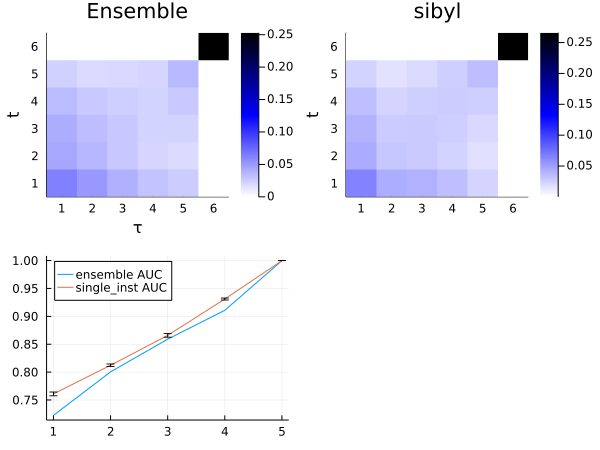

In [45]:
plot_sib = heatmap(sibylmarg2D,c=[:white,:blue,:black],csclxlabel="τ",ylabel="t",title="sibyl") 
plot_ens = heatmap(marg2D,c=[:white,:blue,:black],xlabel="τ",ylabel="t",title="Ensemble")
pAUC = plot(avgAUC(marg),label="ensemble AUC")
pAUC = plot!(AUC,label="single_inst AUC",legend=:topleft,yerr=AUCerr)
plot(plot_ens,plot_sib,pAUC,size = (600,450))
#savefig("ensemble_VS_sibyl")